<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/getting_started_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started with Semantic Segmentation using IceVision

## Introduction to IceVision
IceVision is a Framework for object detection, instance segmentation and semantic segmentation that makes it easier to prepare data, train an object detection model, and use that model for inference.

The IceVision Framework provides a layer across multiple deep learning engines, libraries, models, and data sets.

It enables you to work with multiple training engines, including [fastai](https://github.com/fastai/fastai), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).

It enables you to work with some of the best deep learning libraries including [mmdetection](https://arxiv.org/abs/1906.07155), [Ross Wightman's efficientdet implementation](https://github.com/rwightman/efficientdet-pytorch) and model library, [torchvision](https://pytorch.org/vision/stable/index.html), [ultralytics Yolo](https://github.com/ultralytics/yolov5), and [mmsegmentation](https://github.com/open-mmlab/mmsegmentation).

It enables you to select from many possible models and backbones from these libraries.

IceVision lets you switch between them with ease. This means that you can pick the engine, library, model, and data format that work for you now and easily change them in the future. You can experiment with with them to see which ones meet your requirements.

## Getting Started with Semantic Segmentation

This notebook will walk you through the training of models for **semantic segmentation** - a task that consists in classifying each pixel of an image into one of multiple classes. 

In this tutorial, you will learn how to  
1. Install IceVision. This will include the IceData package that provides easy access to several sample datasets, as well as the engines and libraries that IceVision works with.  
2. Download and prepare a dataset to work with.  
3. Select an object detection library, model, and backbone.  
4. Instantiate the model, and then train it with both the fastai engine.  
5. And finally, use the model to identify objects in images.  

The notebook is set up so that you can easily select different libraries, models, and backbones to try.

## Install

The following downloads and runs a short shell script. The script installs IceVision, IceData, the MMDetection library, the MMSegmentation library and Yolo v5 as well as the fastai and pytorch lightning engines.

Install from pypi...

In [3]:
# Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# Choose your installation target: cuda11 or cuda10 or cpu
!bash icevision_install.sh cuda11

... or from icevision master

In [ ]:
# # Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
# !wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# # Choose your installation target: cuda11 or cuda10 or cpu
# !bash icevision_install.sh cuda11 master

## Imports

In [1]:
from icevision.all import *

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /home/ubuntu/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17
INFO     - The mmseg config folder already exists. No need to downloaded it. Path : /home/ubuntu/.icevision/mmsegmentation_configs/mmsegmentation_configs-0.17.0/configs | icevision.models.mmseg.download_configs:download_mmseg_configs:19


## Getting and parsing the data

Now we can start by downloading the camvid tiny dataset, which contains . This tiny dataset contains 100 images whose pixels are classified in 33 classes, including:
- animal,
- car,
- bridge,
- building.

IceVision provides methods to load a dataset, parse annotation files, and more.

In [2]:
data_url = 'https://s3.amazonaws.com/fast-ai-sample/camvid_tiny.tgz'
data_dir = icedata.load_data(data_url, 'camvid_tiny') / 'camvid_tiny'

Retrieve class codes from dataset file and create a class map (a structure that maps a class identifier, in this case an integer, to the actual class)

In [3]:
codes = np.loadtxt(data_dir/'codes.txt', dtype=str)
class_map = ClassMap(list(codes))

Get images files

In [4]:
images_dir = data_dir/'images'
labels_dir = data_dir/'labels'
image_files = get_image_files(images_dir)

## Parse the dataset

A unit of data in IceVision is called a record, which contains all the information required to handle a given image (e.g. path to the image, segmentation masks, class map, etc..).

Here, we build a collection of records by iterating through the image files.

In [5]:
records = RecordCollection(SemanticSegmentationRecord)

for image_file in pbar(image_files):
    record = records.get_by_record_id(image_file.stem)

    if record.is_new:
        record.set_filepath(image_file)
        record.set_img_size(get_img_size(image_file))
        record.segmentation.set_class_map(class_map)

    mask_file = SemanticMaskFile(labels_dir / f'{image_file.stem}_P.png')
    record.segmentation.set_mask(mask_file)
    
records = records.autofix()
train_records, valid_records = records.make_splits(RandomSplitter([0.8, 0.2]))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

## Take a peak at records

Using `show_records`, we can preview the content of the records we created

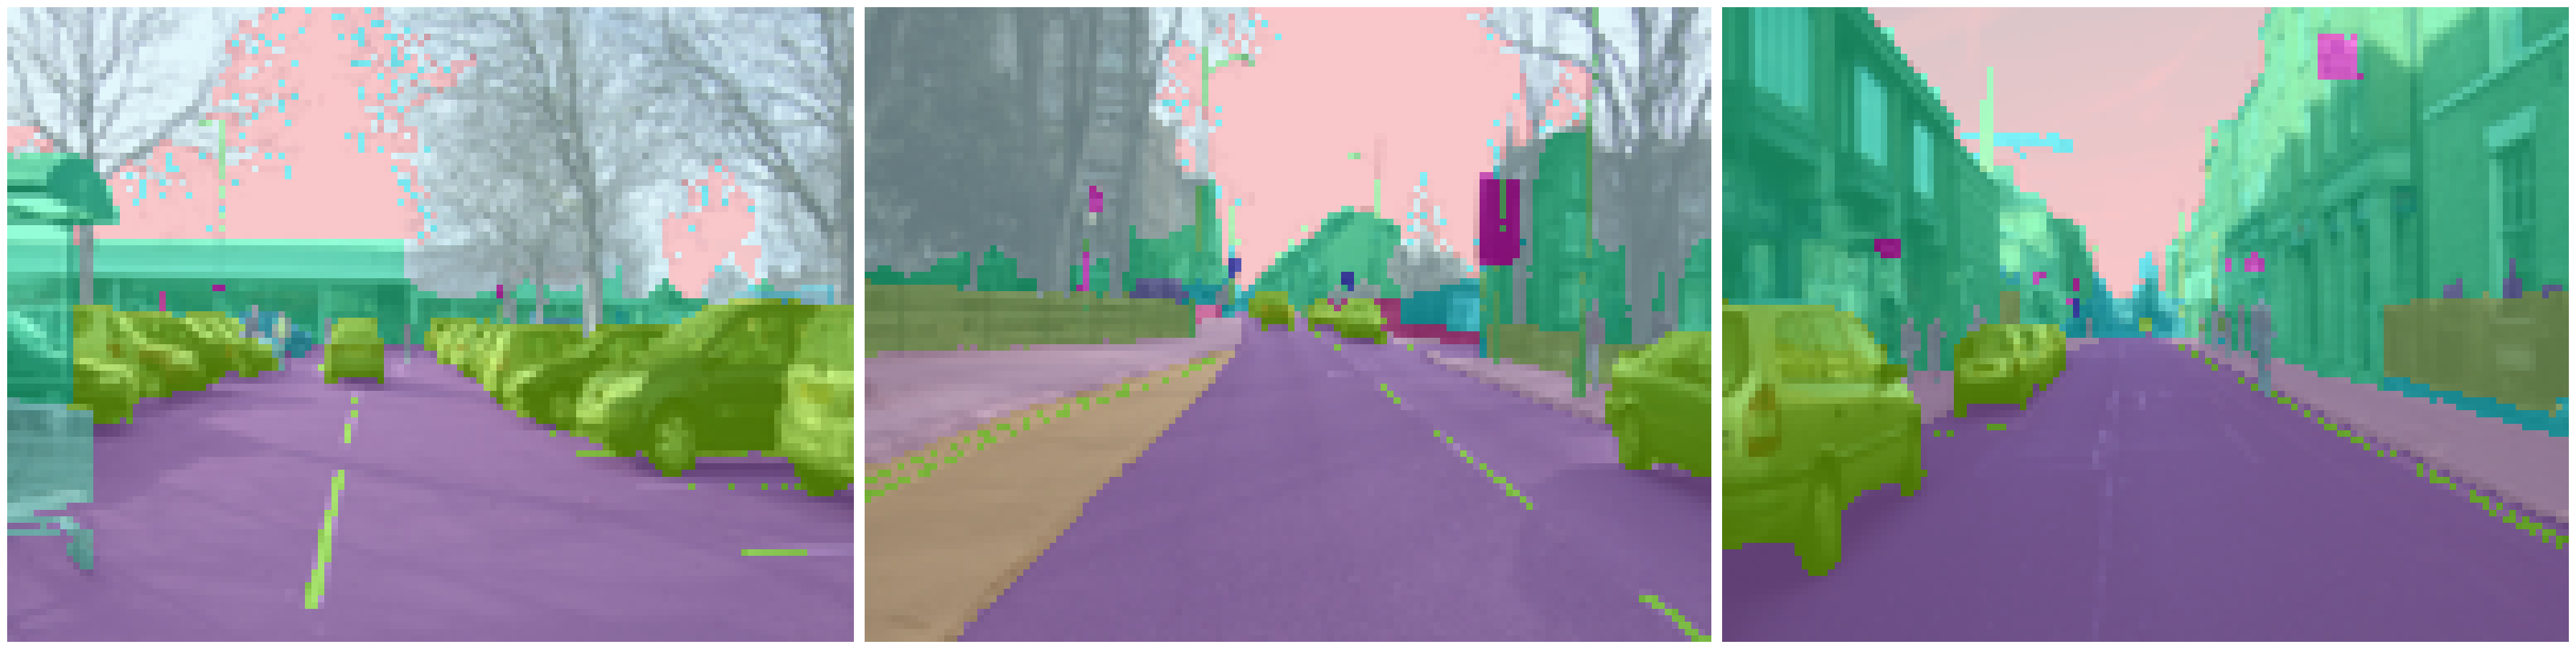

In [6]:
sample_records = random.choices(records, k=3)
show_records(sample_records, ncols=3)

## Creating datasets with augmentations and transforms

Data augmentations are essential for robust training and results on many datasets and deep learning tasks. IceVision ships with the [Albumentations](https://albumentations.ai/docs/) library for defining and executing transformations, but can be extended to use others.

For this tutorial, we apply the Albumentation's default `aug_tfms` to the training set. `aug_tfms` randomly applies broadly useful transformations including rotation, cropping, horizontal flips, and more. See the Albumentations documentation to learn how to customize each transformation more fully.

The validation set is only resized (with padding).

We then create `Datasets` for both. The dataset applies the transforms to the annotations (such as bounding boxes) and images in the data records.

In [7]:
presize, size = 512, 384
presize, size = ImgSize(presize, int(presize*.75)), ImgSize(size, int(size*.75))

aug_tfms = tfms.A.aug_tfms(presize=presize, size=size, pad=None,
                           crop_fn=partial(tfms.A.RandomCrop, p=0.5),
                           shift_scale_rotate=tfms.A.ShiftScaleRotate(rotate_limit=2),
                          )
train_tfms = tfms.A.Adapter([*aug_tfms, tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([tfms.A.resize(size), tfms.A.Normalize()])

In [8]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

### Understanding the transforms

The Dataset transforms are only applied when we grab (get) an item. Several of the default `aug_tfms` have a random element to them. For example, one might perform a rotation with probability 0.5 where the angle of rotation  is randomly selected between +45 and -45 degrees.

This means that the learner sees a slightly different version of an image each time it is accessed. This effectively increases the size of the dataset and improves learning.

We can look at result of getting the 0th image from the dataset a few times and see the differences. Each time you run the next cell, you will see different results due to the random element in applying transformations.

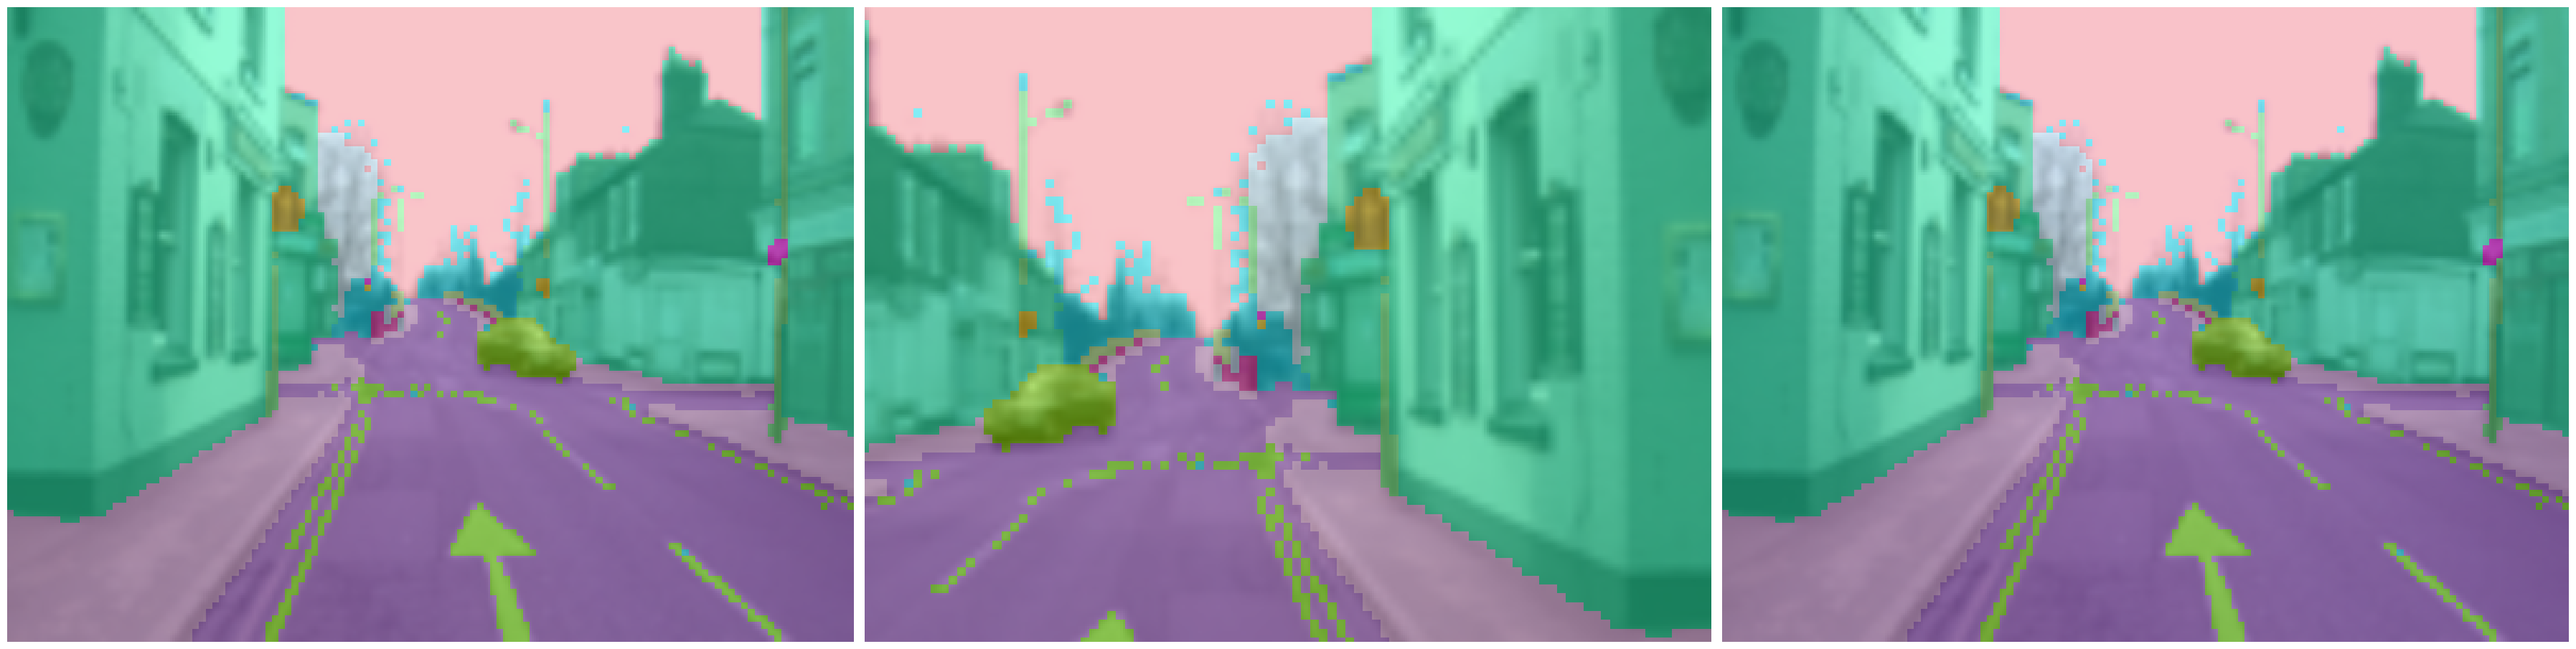

In [9]:
ds_samples = [train_ds[0] for _ in range(3)]
show_samples(ds_samples, ncols=3)

# Select a library, model, and backbone

In order to create a model, we need to:

- Choose one of the **libraries** supported by IceVision
- Choose one of the **models** supported by the library
- Choose one of the **backbones** corresponding to a chosen model

You can access any supported models by following the IceVision unified API, use code completion to explore the available models for each library.

### Creating a model

Selections only take two simple lines of code. For example, to try the `mmsegmentation` library using the `deeplabv3` model and the `resnet50_d8` backbone could be specified by:

```python
model_type = models.mmseg.deeplab3
backbone = model_type.backbones.backbones.resnet50_d8
```

As pretrained models are used by default, we typically leave this out of the backbone creation step.

We've selected a few of the many options below. You can easily pick which option you want to try by setting the value of `selection`. This shows you how easy it is to try new libraries, models, and backbones.

In [ ]:
selection = 1

if selection == 0:
  model_type = models.fastai.unet
  backbone = model_type.backbones.resnet34(pretrained=True)
  model = model_type.model(backbone=backbone, num_classes=class_map.num_classes, img_size=size)

if selection == 1:
  model_type = models.mmseg.deeplabv3
  backbone = model_type.backbones.resnet50_d8(pretrained=True)
  model = model_type.model(backbone=backbone, num_classes=class_map.num_classes)

if selection == 2:
  model_type = models.mmseg.deeplabv3plus
  backbone = model_type.backbones.resnet50_d8(pretrained=True)
  model = model_type.model(backbone=backbone, num_classes=class_map.num_classes)

if selection == 3:
  model_type = models.mmseg.segformer
  backbone = model_type.backbones.mit_b0(pretrained=True)
  model = model_type.model(backbone=backbone, num_classes=class_map.num_classes)

## Data Loader
The Data Loader is specific to a model_type. The job of the data loader is to get items from a dataset and batch them up in the specific format required by each model. This is why creating the data loaders is separated from creating the datasets.

We can take a look at the first batch of items from the `valid_dl`. Remember that the `valid_tfms` only resized (with padding) and normalized records, so different images, for example, are not returned each time. This is important to provide consistent validation during training.

In [11]:
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

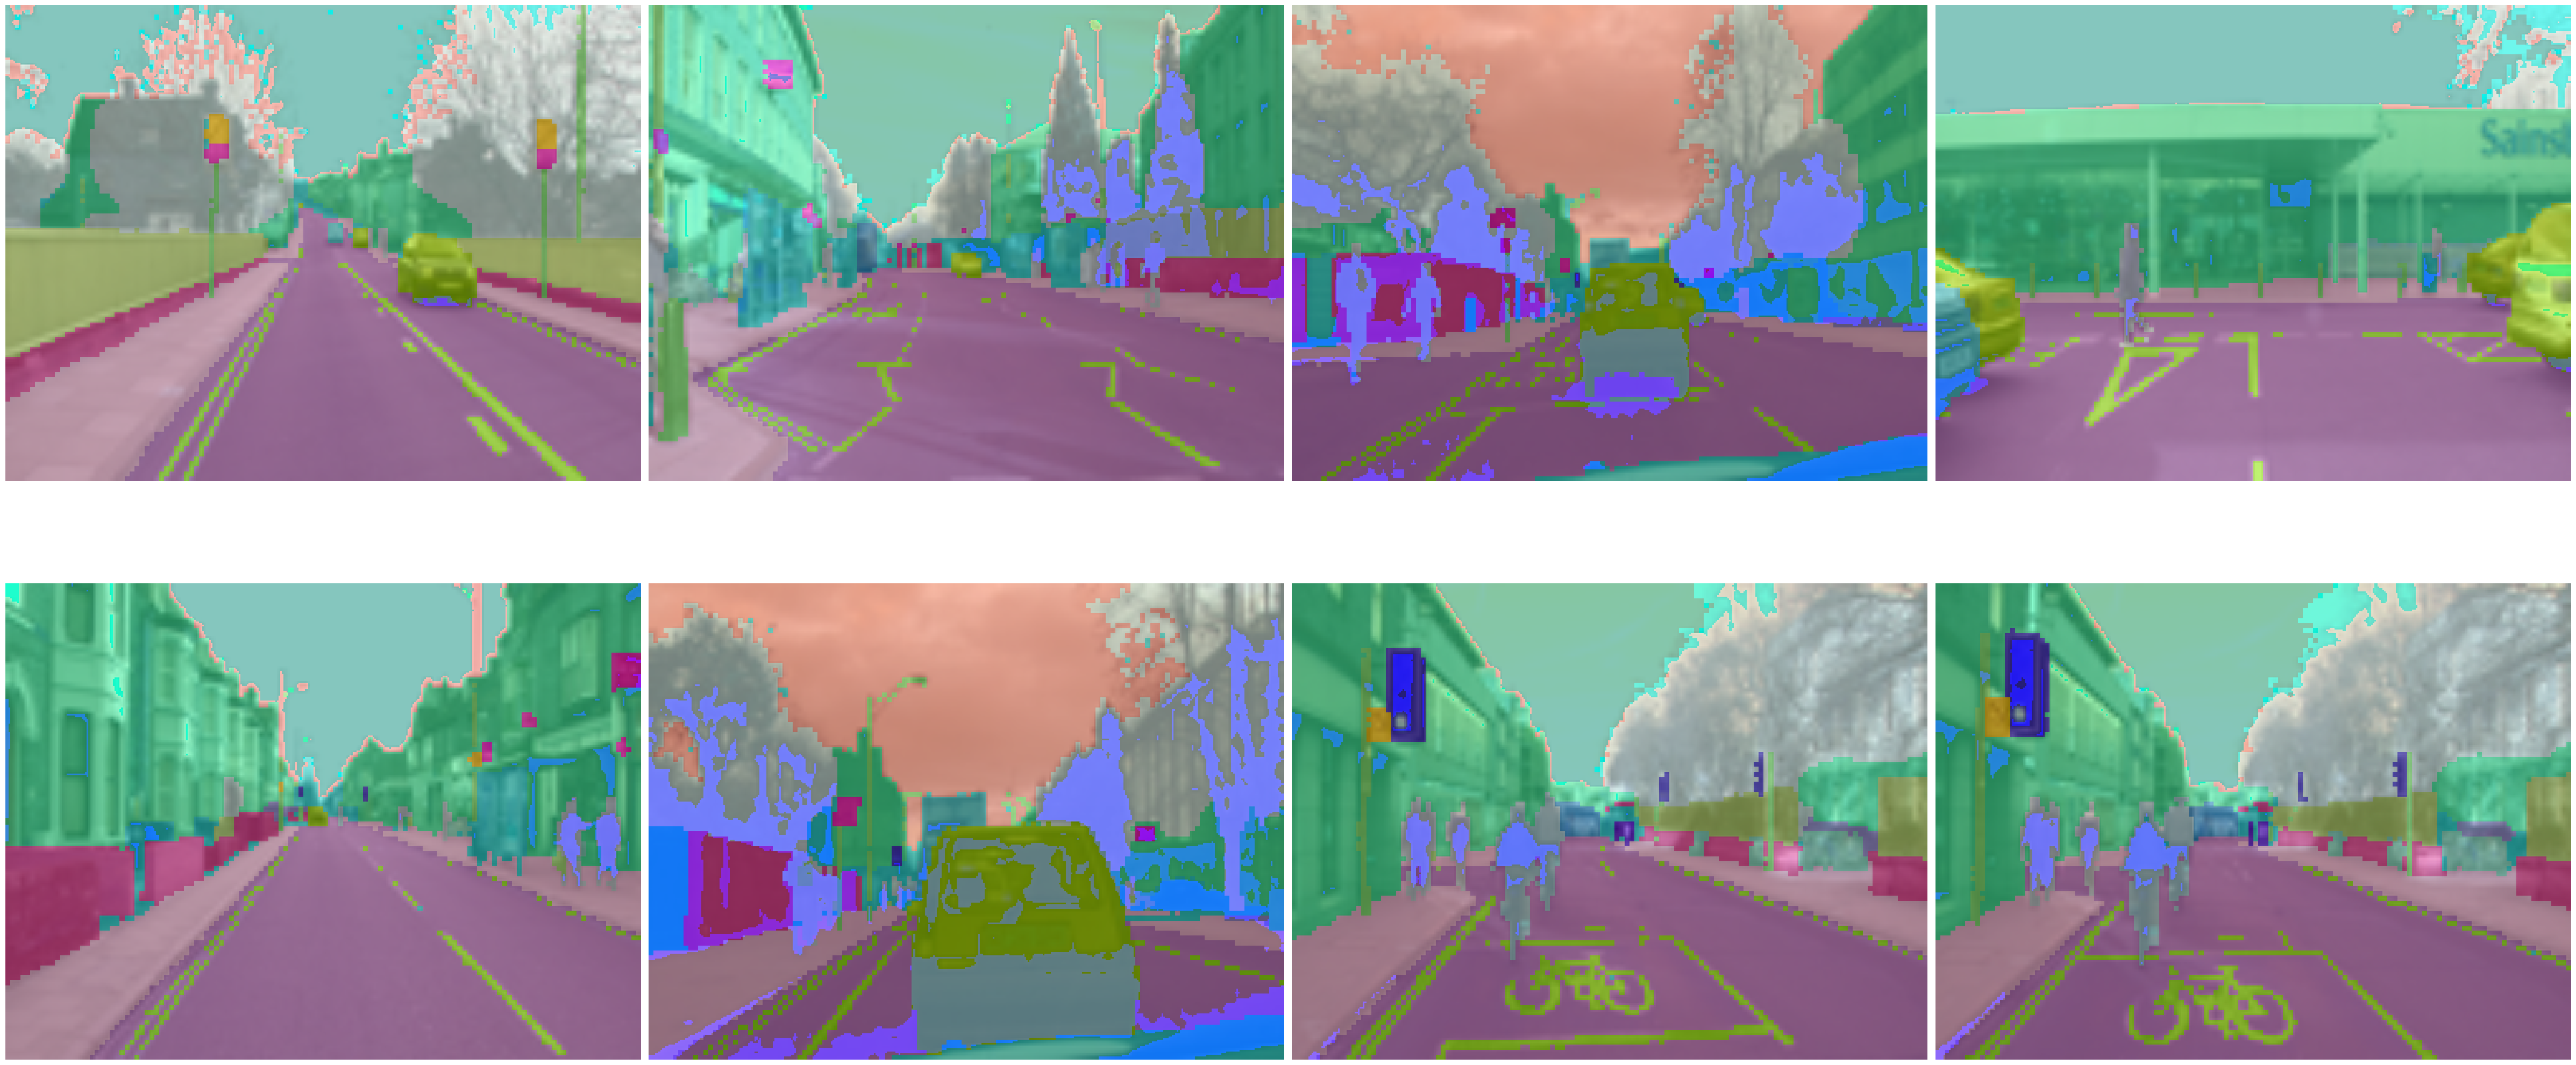

In [12]:
model_type.show_batch(first(valid_dl), ncols=4)

## Metrics

The fastai and pytorch lightning engines collect metrics to track progress during training. IceVision provides metric classes that work across the engines and libraries.

The same metrics can be used for both fastai and pytorch lightning.

As this is a segmentation problem, we are going to use two metrics: multi-class Diece coefficient, and segmentation accuracy. Note that we are ignoring "void" when computing accuracy

In [13]:
metrics = [MulticlassDiceCoefficient(), 
           SegmentationAccuracy(ignore_class=class_map.get_by_name("Void"))]

## Training

IceVision is an agnostic framework meaning it can be plugged into other DL learning engines such as [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).  


### Training using fastai

In [14]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

Because we use fastai, we get access to its features such as the learning rate finder

SuggestedLRs(valley=0.0005754399462603033)

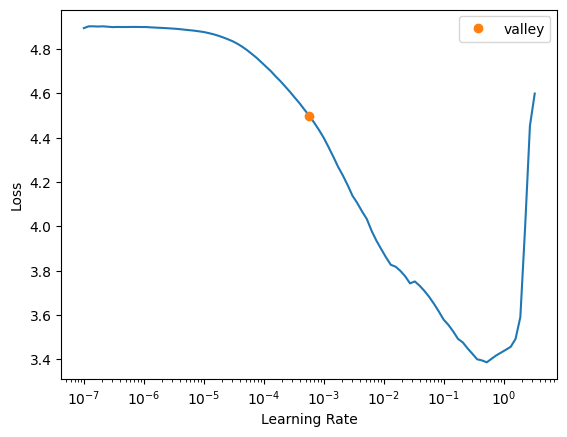

In [15]:
learn.lr_find()

In [16]:
learn.fine_tune(10, 1e-4)

epoch,train_loss,valid_loss,MulticlassDiceCoefficient,SegmentationAccuracy,time
0,4.716942,4.197937,0.180845,0.789499,00:21


epoch,train_loss,valid_loss,MulticlassDiceCoefficient,SegmentationAccuracy,time
0,4.232966,4.128767,0.226597,0.806884,00:18
1,4.154363,3.961988,0.235534,0.809175,00:18
2,4.067923,3.820444,0.254283,0.813158,00:19
3,3.982723,3.734250,0.277850,0.819631,00:18
4,3.902324,3.667058,0.287838,0.822533,00:18
5,3.830899,3.627812,0.292731,0.821733,00:18
6,3.768515,3.586231,0.293273,0.825096,00:18
7,3.714865,3.549266,0.298292,0.826219,00:17
8,3.669041,3.539322,0.298289,0.827088,00:18
9,3.630552,3.543171,0.299139,0.826904,00:18


## Using the model - inference and showing results

The first step in reviewing the model is to show results from the validation dataset. This is easy to do with the `show_results` function.

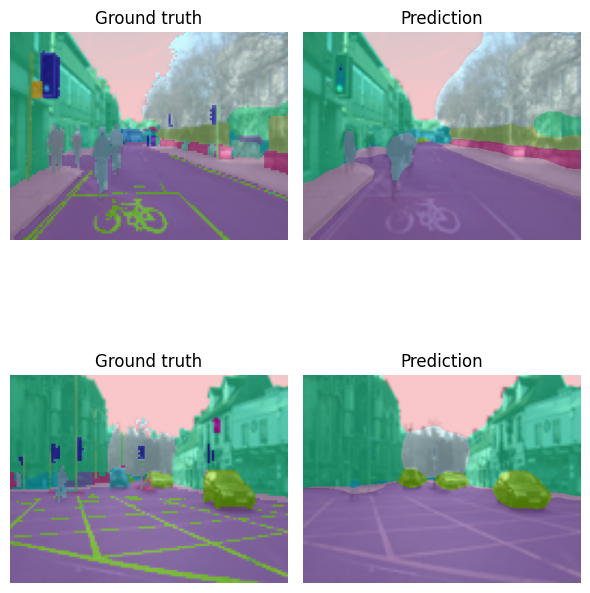

In [17]:
model_type.show_results(model, valid_ds, num_samples=2)

### Prediction

Sometimes you want to have more control than `show_results` provides. You can construct an inference dataloader using `infer_dl` from any IceVision dataset and pass this to `predict_dl` and use `show_preds` to look at the predictions.

A prediction is returned as a dict with keys: `scores`, `labels`, `bboxes`, and possibly `masks`. 

Prediction functions that take a `keep_images` argument will only return the (tensor representation of the) image when it is `True`. In interactive environments, such as a notebook, it is helpful to see the image with bounding boxes and labels applied. In a deployment context, however, it is typically more useful (and efficient) to return the bounding boxes by themselves.

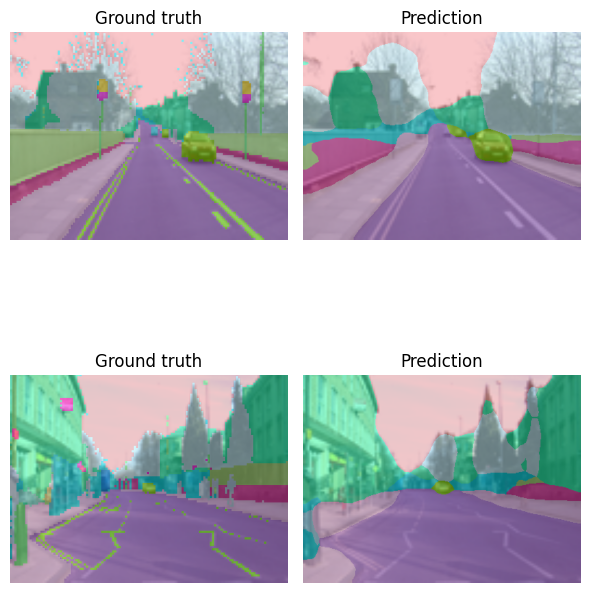

In [18]:
preds = model_type.predict(model, valid_ds)
show_preds(preds=preds[:2])

In [19]:
infer_dl = model_type.infer_dl([valid_ds[0]], batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/1 [00:00<?, ?it/s]

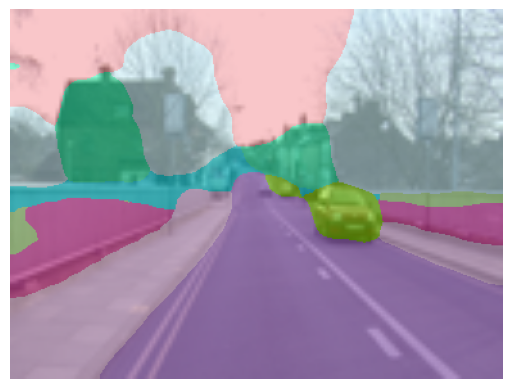

In [20]:
show_sample(preds[0].pred)

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).